# Energy calibration examples

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import becquerel as bq

Let's load an HPGe spectrum from a file and apply a calibration. This file will generate a warning because its calibration is invalid.

In [2]:
spec = bq.Spectrum.from_file('../tests/samples/digibase_5min_30_1.spe')

SpeFile: Reading file ../tests/samples/digibase_5min_30_1.spe


becquerel/parsers/spectrum_file.py:135: SpectrumFileParsingWarning: Spectrum will be initated without an energy calibration;invalid calibration, energies not monotonically increasing.
  SpectrumFileParsingWarning)


Did an energy calibration get loaded from the file?

In [3]:
spec.is_calibrated

False

Let's take a look at the spectrum. We happen to know that this spectrum contains background, Cesium-137, and Cobalt-60.

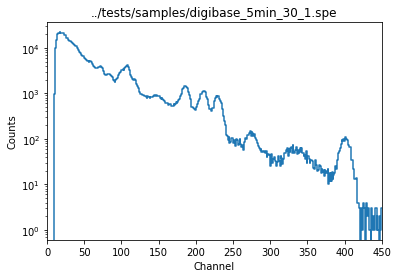

In [4]:
spec.plot(xmode='channel', yscale='log')
plt.xlim(0, 450);

For any calibration, we will need to determine the centroids of peaks of known energies. In this spectrum, the 662 keV line is around channel 110, the 1460 keV line is around channel 230, and the 2614 keV line is around channel 400. Here is a simple way of finding those peaks by finding the maximum channel in those regions, although better practice would be to fit a function to the line regions.

becquerel/core/spectrum.py:379: UserWarning: channels is deprecated terminology and will be removed in a future release. Use the property `bins` instead.
  warnings.warn('channels is deprecated terminology and will be removed '


[108, 227, 401]


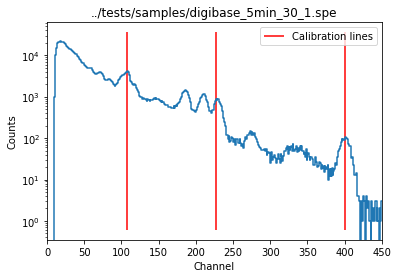

In [5]:
energies = [661.7, 1460.8, 2614.5]
channels = []
ch_ranges = [(100, 120), (220, 240), (380, 420)]
for ch_min, ch_max in ch_ranges:
    ch_range = (ch_min <= spec.channels) & (spec.channels <= ch_max)
    chans = spec.channels[ch_range]
    counts = spec.counts[ch_range]
    ch_peak = chans[counts == counts.max()][0]
    channels.append(ch_peak)
print(channels)

spec.plot(xmode='channel', yscale='log')
plt.xlim(0, 450)
plt.vlines(channels, *plt.gca().get_ylim(), color='red', label='Calibration lines')
plt.legend();

## `LinearEnergyCal` example

One can instantiate a `LinearEnergyCal` or any other calibration in two ways:
1. `from_coeffs(dict)` class method where the dictionary is a dictionary of calibration coefficients (e.g., `{'slope': 1.0, 'offset': 0.0}`)
2. `from_points(chlist, kevlist)` class method with channels and energies of calibration points. A fit is automatically performed to generate the best coefficients.

Let's create a calibration from points:

In [6]:
cal = bq.LinearEnergyCal.from_points(channels, energies)

The coefficents are automatically fit to those points:

In [7]:
cal.coeffs

{'b': 6.662320587016257, 'c': -55.48931734798846}

Sometimes one may want to include the point (0, 0) in the calibration to make the calibration pass closer to the origin:

In [8]:
cal = bq.LinearEnergyCal.from_points([0, *channels], [0, *energies])
cal.coeffs

{'b': 6.54704414587332, 'c': -20.40612284069107}

This case is automatically handled using the `include_origin` kwarg:

In [9]:
cal = bq.LinearEnergyCal.from_points(channels, energies, include_origin=True)
cal.coeffs

{'b': 6.54704414587332, 'c': -20.40612284069107}

Here is a calibration instantiated using coefficients:

In [10]:
cal = bq.LinearEnergyCal.from_coeffs({'b': 6.6612, 'c': -55.489})
cal.coeffs

{'b': 6.6612, 'c': -55.489}

The calibration can be applied to our `Spectrum` to generate energies from channels:

In [11]:
spec.apply_calibration(cal)
spec.is_calibrated

True

Now we should be able to plot the spectrum and see that the Co-60 lines are at the correct energies:

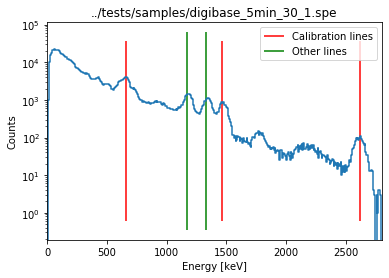

In [12]:
spec.plot(xmode='energy', yscale='log')
plt.vlines(energies, *plt.gca().get_ylim(), color='red', label='Calibration lines')
plt.vlines([1173, 1333], *plt.gca().get_ylim(), color='green', label='Other lines')
plt.xlim(0, 2800)
plt.legend();